In [1]:
import pandas as pd
import numpy as np

In [2]:
data = []
temp = []
for i in open('shakespeare.txt'):
    s = i.lower().lstrip()
    if len(s.split())<2:
        if len(temp) >0:
            data.append(temp)
        temp = []
        continue
    temp.append(s)
data.append(temp)

In [3]:
len(data)

154

In [4]:
from nltk.corpus.reader.api import *
from nltk.corpus.reader.util import *
from nltk.util import Index

In [5]:
from nltk.corpus import cmudict
from nltk.tokenize import sent_tokenize,wordpunct_tokenize

In [6]:
import nltk
import string

In [7]:
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to /home/suk012/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

In [8]:
cd = cmudict.dict()

In [9]:
for i in data[0][0].split():
    temp = i.translate(str.maketrans('', '', string.punctuation))
    print(temp)
    print(cd[temp][0])

from
['F', 'R', 'AH1', 'M']
fairest
['F', 'EH1', 'R', 'IH0', 'S', 'T']
creatures
['K', 'R', 'IY1', 'CH', 'ER0', 'Z']
we
['W', 'IY1']
desire
['D', 'IH0', 'Z', 'AY1', 'ER0']
increase
['IH0', 'N', 'K', 'R', 'IY1', 'S']


In [10]:
##syllable tokenization

In [11]:
syllDict = {}
for i in open('Syllable_dictionary.txt'):
    temp = i.split()
    syllDict[temp[0]] = temp[1]

In [55]:
words = []
for d in data:
    for i in d:
        words+=wordpunct_tokenize(i)

In [56]:
words=(list(set(words)))+['\n']

In [57]:
words_idx = {w:i for i,w in enumerate(words)}
idx_words = {i:w for i,w in enumerate(words)}

In [58]:
data_word = []
for d in data:
    temp = []
    for i in d:
        temp+=wordpunct_tokenize(i)+['\n']
    data_word.append(temp)

In [59]:
for i,d in enumerate(data_word):
    temp = []
    for w in d:
        temp.append(words_idx[w])
    data_word[i] = temp

In [68]:
syll_words = []
for d in words:
    temp = []
    for i in words:
        if i in syllDict:
            temp.append(int(syllDict[i][-1]))
        else:
            temp.append(0)
    syll_words.append(temp)

In [12]:
## character level RNN

In [13]:
chars = set()
for i in data:
    temp = ""
    for j in i:
        temp=temp+j
    chars = chars.union(set(list(temp)))
chars = sorted(chars)

In [14]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.distributions import Categorical

In [16]:
device = torch.device('cuda')

In [17]:
dataset = []
for i, s in enumerate(data):
    
    temp =""
    for l in s:
        temp+=l
    temp = list(temp)
    for j, ch in enumerate(temp):
        temp[j] = char_to_ix[ch]
    dataset.append(temp)

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, output_size, hidden_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax()
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        #output = self.softmax(output)
        return output, (hidden_state[0], hidden_state[1])

In [19]:
model = RNN(input_size=len(chars), embedding_size=len(chars), output_size=len(chars), hidden_size=256).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())#, lr=1e-4)

In [20]:
epochs = 20

for i_epoch in range(1, epochs+1):
        
    n = 0
    running_loss = 0
    for d in tqdm(range(len(dataset))):
        d = torch.tensor(dataset[d]).to(device)
        for i in range(40,len(d)-1,7):
            hidden_state = None
            input_seq = d[i-40 : i]
            target_seq = d[i-40+1 : i+1]
            # forward pass
            output, _ = model(input_seq, hidden_state)
            #print(input_seq,target_seq,output)

            # compute loss
            loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq)) 
            running_loss += loss.item()
            n += 1

            # compute gradients and take optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # print loss after every epoch
    print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss/n))

100%|██████████| 154/154 [01:22<00:00,  1.88it/s]


Epoch: 1 	 Loss: 1.78435286


100%|██████████| 154/154 [01:21<00:00,  1.90it/s]


Epoch: 2 	 Loss: 1.58508797


100%|██████████| 154/154 [01:21<00:00,  1.89it/s]


Epoch: 3 	 Loss: 1.51682984


100%|██████████| 154/154 [01:22<00:00,  1.86it/s]


Epoch: 4 	 Loss: 1.47270482


100%|██████████| 154/154 [01:26<00:00,  1.78it/s]


Epoch: 5 	 Loss: 1.43533315


100%|██████████| 154/154 [01:20<00:00,  1.91it/s]


Epoch: 6 	 Loss: 1.40608571


100%|██████████| 154/154 [00:59<00:00,  2.60it/s]


Epoch: 7 	 Loss: 1.37885479


100%|██████████| 154/154 [01:22<00:00,  1.88it/s]


Epoch: 8 	 Loss: 1.35620974


100%|██████████| 154/154 [01:21<00:00,  1.90it/s]


Epoch: 9 	 Loss: 1.33539440


100%|██████████| 154/154 [01:24<00:00,  1.82it/s]


Epoch: 10 	 Loss: 1.31951436


100%|██████████| 154/154 [01:21<00:00,  1.90it/s]


Epoch: 11 	 Loss: 1.30361331


100%|██████████| 154/154 [01:22<00:00,  1.86it/s]


Epoch: 12 	 Loss: 1.29312238


100%|██████████| 154/154 [01:23<00:00,  1.85it/s]


Epoch: 13 	 Loss: 1.27742322


100%|██████████| 154/154 [01:25<00:00,  1.80it/s]


Epoch: 14 	 Loss: 1.26237014


100%|██████████| 154/154 [01:24<00:00,  1.82it/s]


Epoch: 15 	 Loss: 1.25514320


100%|██████████| 154/154 [01:24<00:00,  1.82it/s]


Epoch: 16 	 Loss: 1.24616098


100%|██████████| 154/154 [01:24<00:00,  1.82it/s]


Epoch: 17 	 Loss: 1.23942875


100%|██████████| 154/154 [01:23<00:00,  1.84it/s]


Epoch: 18 	 Loss: 1.23226866


100%|██████████| 154/154 [01:24<00:00,  1.82it/s]


Epoch: 19 	 Loss: 1.22587442


100%|██████████| 154/154 [01:24<00:00,  1.82it/s]

Epoch: 20 	 Loss: 1.21745815


In [21]:
prompt = "shall i compare thee to a summer's day\n"
prompt = list(prompt)
for i, ch in enumerate(prompt):
    prompt[i] = char_to_ix[ch]
for t in [0.25,0.75,1,1.5]:
    with torch.no_grad():
        prompt = torch.tensor(prompt).to(device).long()
        hidden_state = None

        for _ in range(40):

             # forward pass
            output, hidden_state = model(prompt, hidden_state)

            # construct categorical distribution and sample a character
            output = F.softmax(torch.squeeze(output[-1]/t), dim=0)
            dist = Categorical(output)
            index = dist.sample()

            # print the sampled character
            print(ix_to_char[index.item()], end='')

            # next input is current output
            prompt = torch.cat([prompt[1:], index.unsqueeze(0)])
        print()
        print()
        print('for T: '+str(t))
        print()


/tmp/ipykernel_964/1361728061.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt = torch.tensor(prompt).to(device).long()


and by and loving the brave mine eyes to

for T: 0.25

 prevawers i am not enloten,
that i do i

for T: 0.75

 hall eyes the store,
and live, the lere

for T: 1

rtai advanfuupt it,
and i bold the stray

for T: 1.5



In [22]:
torch.save(model.state_dict(), 'weights.pt')

In [23]:
#3

In [29]:
class wordRNN(nn.Module):
    def __init__(self, input_size, embedding_size, output_size, hidden_size):
        super(wordRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)

        self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0], hidden_state[1])

In [30]:
wordmodel = wordRNN(input_size=len(words), 
            embedding_size=300, 
            output_size= len(words), 
            hidden_size=256).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wordmodel.parameters())

In [31]:
epochs = 20
losses = []
for i_epoch in tqdm(range(1, epochs+1)):
        
    n = 0
    running_loss = 0
    for d in data_word:
        d=torch.tensor(d).to(device)
        for i in range(10,len(d)-1):
            hidden_state = None
            input_seq = d[i-10 : i]
            target_seq = d[i-10+1 : i+1]

            # forward pass
            output, _ = wordmodel(input_seq, hidden_state)
            # compute loss
            loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq)) 
            running_loss += loss
            n += 1

            # compute gradients and take optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    losses.append(running_loss/n)   
    # print loss after every epoch
    #perplexity  = np.exp(running_loss)/n
    #print("Epoch: {0} \t Loss: {1:.8f} \t Perplexity: {1:.8f}".format(i_epoch, running_loss/5, perplexity))

100%|██████████| 20/20 [32:31<00:00, 97.60s/it] 


In [32]:
losses

[tensor(4.6956, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5918, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.3085, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.9923, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.7139, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4444, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.2190, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.0107, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.8394, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.6527, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.4890, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.3425, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.1953, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.0557, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.9446, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.8176, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.7171, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.6110

In [33]:
prompt = "shall i compare thee to a summer's day\n"
prompt = wordpunct_tokenize(prompt)
for i, ch in enumerate(prompt):
    prompt[i] = words_idx[ch]

for T in [0.25,0.75,1,1.5]:
    with torch.no_grad():
        prompt = torch.tensor(prompt).to(device).long()
        hidden_state = None

        for _ in range(50):

             # forward pass
            output, hidden_state = wordmodel(prompt, hidden_state)

            # construct categorical distribution and sample a character
            output = F.softmax(torch.squeeze(output[-1]/T), dim=0)
            dist = Categorical(output)
            index = dist.sample()

            # print the sampled character
            print(idx_words[index.item()], end=' ')

            # next input is current output
            prompt = torch.cat([prompt[1:], index.unsqueeze(0)])
        print()
        print()
        print('for T: '+str(T))
        print()

/tmp/ipykernel_964/3346784667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt = torch.tensor(prompt).to(device).long()


? 
 whence hast thou this becoming of things ill , 
 that in the very refuse of thy deeds , 
 there is such strength and warrantise of skill , 
 that in my mind thy worst all best exceeds ? 
 who taught thee how to make me 

for T: 0.25

love thee more , 
 the more perjured , murd ' rous , bloody full of blame , 
 savage , extreme , rude , cruel , not to love ' s so blessed - fair that fears for fair subject , blessing in her sake ? 
 no , 

for T: 0.75

let me be obsequious in thy heart , 
 that in thy face hath love put in my head , 
 which more red to me her love , with tears thou keep ' st me blind , 
 lest eyes well - seeing thy foul faults should find , 

for T: 1


 that her novel bases for let nature ' s this poor thee a they self ring ) the humble ' s fickle hour : 
 who hast by waning grown , and therein show ' st , 
 thy lovers withering , as my poor april i lose through 

for T: 1.5



In [ ]:
torch.save(wordmodel.state_dict(), 'wordweights.pt')

In [40]:
class wordRNN(nn.Module):
    def __init__(self, input_size, num_layers, embedding_size, output_size, hidden_size):
        super(wordRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)

        self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size)
        self.rnn_layers = nn.ModuleList([
            nn.LSTM(input_size=hidden_size, hidden_size=hidden_size)
            for _ in range(num_layers - 1)
        ])
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        for rnn_layer in self.rnn_layers:
            output, hidden_state = rnn_layer(output, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0], hidden_state[1])

In [41]:
wordmodel2 = wordRNN(input_size=len(words), 
            num_layers = 3,         
            embedding_size=300, 
            output_size= len(words), 
            hidden_size=256).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wordmodel2.parameters())

In [42]:
epochs = 20
losses2 = []
for i_epoch in tqdm(range(1, epochs+1)):
        
    n = 0
    running_loss = 0
    for d in data_word:
        d=torch.tensor(d).to(device)
        for i in range(10,len(d)-1,4):
            hidden_state = None
            input_seq = d[i-10 : i]
            target_seq = d[i-10+1 : i+1]

            # forward pass
            output, _ = wordmodel2(input_seq, hidden_state)
            # compute loss
            loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq)) 
            running_loss += loss
            n += 1

            # compute gradients and take optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    losses2.append(running_loss/n)
    # print loss after every epoch
    #perplexity  = np.exp(running_loss)/n
    #print("Epoch: {0} \t Loss: {1:.8f} \t Perplexity: {1:.8f}".format(i_epoch, running_loss/5, perplexity))

100%|██████████| 20/20 [16:25<00:00, 49.28s/it]


In [44]:
losses2

[tensor(5.4077, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.3606, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.7230, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.1410, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.6207, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.1505, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.7450, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.4068, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.1415, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9458, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.7867, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.6645, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5918, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5221, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4863, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4462, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4195, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3975

In [43]:
torch.save(wordmodel2.state_dict(), 'wordweights2.pt')

In [45]:
prompt = "shall i compare thee to a summer's day\n"
prompt = wordpunct_tokenize(prompt)
for i, ch in enumerate(prompt):
    prompt[i] = words_idx[ch]

for T in [0.25,0.75,1,1.5]:
    with torch.no_grad():
        prompt = torch.tensor(prompt).to(device).long()
        hidden_state = None

        for _ in range(50):

             # forward pass
            output, hidden_state = wordmodel2(prompt, hidden_state)

            # construct categorical distribution and sample a character
            output = F.softmax(torch.squeeze(output[-1]/T), dim=0)
            dist = Categorical(output)
            index = dist.sample()

            # print the sampled character
            print(idx_words[index.item()], end=' ')

            # next input is current output
            prompt = torch.cat([prompt[1:], index.unsqueeze(0)])
        print()
        print()
        print('for T: '+str(T))
        print()

be 
 to make thee lie , all ' s love ' s field , 
 love ' s love , all men to misuse a store ' s discontent . 
 for beauty doth tell , to bear his day . 
 who beauty doth come , let in 

for T: 0.25

my friend . 
 that i may am , now is hanging not not , 
 not were not abhor the clock which he which me , 
 not reason , which he by heaven but more : 
 not shall not live ' she hear in me . 
 

for T: 0.75

o eyes the unworthiness are bear thy heart . 
 that none , i say not that i am see thee how 
 upon my friend are fell reason 

/tmp/ipykernel_964/2416721394.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt = torch.tensor(prompt).to(device).long()


: 
 but that by vow ( such fair repair doth prove a ill , 
 a brand votary still ' 

for T: 1

s son , 
 and grew must men , all men men prove most . 
 even all my love away be oaths away so make thee this : 
 then i shall not call thee give thee cruel 
 to many thy hope broke , make bear 
 in 

for T: 1.5



In [48]:
import matplotlib.pyplot as plt

In [52]:
for i,l in enumerate(losses):
    losses[i] = float(l)

In [53]:
for i,l in enumerate(losses2):
    losses2[i] = float(l)

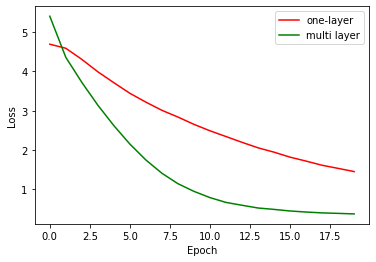

In [54]:
plt.plot(np.array(losses), color='r', label='one-layer')
plt.plot(np.array(losses2), color='g', label='multi layer')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()